In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate, integrate, optimize, stats
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)

import time
import pycbc.conversions as conv
import corner

from gwbench import injections
from gwbench import network
from gwbench import snr

In [2]:
plotdir = 'power_law_hyper_param_plots/'

alpha_inj = -3.5
mmin_inj = 5.0
mmax_inj = 100.
# mmax_inj = 60.

import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)

# Read simulation

In [3]:
# File with Mc biases

# files = [f'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc.csv']
# files = ['powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_2400_4800.csv', \
#     'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_4800_7200.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_Mc_7200_10080.csv']

# files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc.csv']
files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc.csv', 'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_Mc_2400_10080.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_mc_raw = df1.loc[~(df1==0).all(axis=1)]
df_mc_raw = df_mc_raw[df_mc_raw["Mc"] > 0]
# df_mc_raw = df_mc_raw[(df_mc_raw["m1"]/(1+df_mc_raw["z"])) <= 60.]
# df_mc_raw = df_mc_raw[df_mc_raw["z"] < 2]
print("Total number of events:",len(df_mc_raw))


Total number of events: 10080


In [4]:
# File with eta biases

# files = [f'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta.csv']
# files = ['powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_2400_4800.csv', \
    # 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_4800_7200.csv', 'powerlaw_3.5_lams_analytic/powerlaw_alpha_3.5_lam_0_1_eta_7200_10080.csv']
#
# files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta.csv']
files = [f'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta.csv', 'powerlaw_3.5_lams_fine/powerlaw_alpha_3.5_lam_0_1_eta_2400_10080.csv']


df1 = pd.DataFrame()
for fi in files:
    df_temp = pd.read_csv(fi)
    df1 = df1.append(df_temp)
# drop the zero rows that resulted from NoneType Networks
df_eta_raw = df1.loc[~(df1==0).all(axis=1)]
df_eta_raw = df_eta_raw[df_eta_raw["Mc"] > 0]
# df_eta_raw = df_eta_raw[(df_eta_raw["m1"]/(1+df_eta_raw["z"])) <= 60.]
# df_eta_raw = df_eta_raw[df_eta_raw["z"] < 2]
print("Total number of events:",len(df_eta_raw))

Total number of events: 10080


## Sample from the events if needed

In [5]:
# # Select random subset of the data
# n_samples = 1200
# sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
# df_mc = df_mc_raw.iloc[sample_indices]
# df_eta = df_eta_raw.iloc[sample_indices]

# select all data
df_mc = df_mc_raw
df_eta = df_eta_raw

print(len(df_mc))
print(np.median(df_mc["Mc"]))

10080
14.235779623328058


$$ p(\alpha) = e^{-N_s} \Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) $$

The products are over all events. 

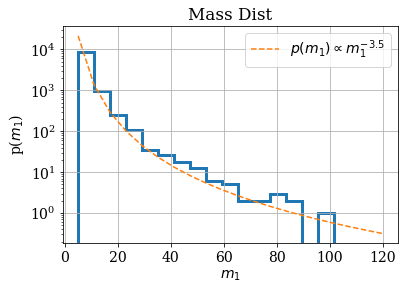

In [6]:
bins = np.linspace(5, 120, 20)

m1_inj = df_mc["m1"]/(1+df_mc["z"])
# y, X = np.histogram(m1_inj, bins=bins, density=True)
# X = X[:-1]
# plt.plot(X, y, 'bo', label='Injected')

plt.hist(m1_inj, bins, histtype='step', lw=3)
plt.plot(bins, 6000000*bins**(alpha_inj), linestyle='--', label='$p(m_1) \propto m_1^{-3.5}$')
plt.grid()
plt.semilogy()

plt.xlabel("$m_1$")
plt.ylabel("p($m_1$)")
plt.title("Mass Dist")
plt.legend()


plt.savefig("powerlaw_3.5_plots/powerlaw_m1_dist.pdf")
plt.show()

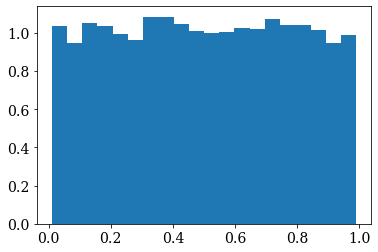

In [7]:
# bins=np.geomspace(0.00001,4.0, 30)

# plt.hist(df_mc_raw["bias_1"], bins=bins, density=True)
# plt.hist(df_mc_raw["bias_1"][df_mc_raw["Mc"]>20], bins=bins, density=True, histtype="step")
# plt.semilogx()
# plt.show()
# plt.hist(df_eta_raw["bias_1"], bins=bins, density=True)
# plt.hist(df_eta_raw["bias_1"][df_eta_raw["snr"]>8], bins=bins, density=True, histtype="step")
# plt.semilogx()
# plt.show()

# plt.hist(df_eta_raw["snr"], bins=np.geomspace(1, 500, 30))
# plt.semilogx()
# plt.show()

plt.hist(1/df_mc_raw["q"], bins=20, density=True)
# plt.semilogx()
plt.show()

Or, in log likelihood space, 
$$ log(p(\alpha)) = log(e^{-N_s}) + log(\Gamma_{i=1}^{N_t} N_s \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1) )$$

which simplifies to 

$$ log(p(\alpha)) = -N_s + \Sigma_{i=1}^{N_t} log(N_s * \int_{m_{1, min}}^{m_{1, max}} \rm{d} m_1 \pi(m_1 | \alpha ') p(d_i | m_1)) $$

#  Define the functions

In [8]:
def sample_m1_events(df_mc, df_eta, biased=False):
    z = df_mc["z"]
    mchirp = df_mc["Mc"]/ (1+z)
    eta = df_mc["eta"]

    sigMc_raw = df_mc["Mc_stat_err"]
    sigEta = df_eta["eta_stat_err"]
    sigZ = df_mc["z_stat_err"]

    # sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


    m1_mu_detections = df_mc["m1"] / (1+z)

    aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
    aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
    aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
    aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
    m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
    m1_sigma_events = m1_sigma_events.values

    if biased:
        bias_mc = df_mc["bias_19"]
        bias_eta = df_eta["bias_19"]
    
        mchirp_biased = (df_mc["Mc"] + bias_mc) / (1+z)
        eta_biased = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m1_mu_detections = conv.mass1_from_mchirp_eta(mchirp_biased, eta_biased)
        
    # sample mu from the detection gaussians to avoid Biases
    # m1_mu_sampled = stats.truncnorm.rvs(0, 1000, m1_mu_detections, m1_sigma_events)
    m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

    return m1_mu_sampled, m1_sigma_events

In [9]:
def get_cofidence_int_1d(log_norm, range):
    # 68% confidence interval using KDE
    cdf_likelihood = integrate.cumulative_trapezoid(np.exp(log_norm), range, initial=0)
    cdf_likelihood = cdf_likelihood/np.max(cdf_likelihood)

    # make sure the cdf is strictly increasing to interpolate
    index_min = np.where(cdf_likelihood == np.min(cdf_likelihood))[0][0]
    index_max = np.where(cdf_likelihood == np.max(cdf_likelihood))[0][0]

    inv_cdf_interp = interpolate.interp1d(cdf_likelihood[index_min:index_max], range[index_min:index_max], fill_value="extrapolate")


    med = inv_cdf_interp(0.5)
    sig_pos = inv_cdf_interp(0.84)
    sig_neg = inv_cdf_interp(0.16)

    return med, sig_pos, sig_neg

In [10]:
def p_m1(m1, alpha, m_min, m_max):
    '''
    BBH merger primary mass PDF.
    '''
    if alpha != -1:
        N1 = 1 / ((m_max**(alpha+1) - m_min**(alpha+1))/(alpha+1))
    else:
        N1 = 1/(np.log(m_max/m_min))

    return np.piecewise(m1, [(m1 < m_min), (m1 >= m_min)*(m1 < m_max), (m1 >= m_max)],
                        [0, lambda m1: N1*m1**alpha, 0])


def normal_dist(m1, mu, sigma, amp=1.0):
    A = np.sqrt(2*np.pi) * sigma
    return amp * np.exp(-(m1 - mu) ** 2 / (2 * sigma**2)) / A
    # return stats.norm.pdf(m1, loc=mu, scale=sigma)

def trunc_normal_dist(m1, mu, sigma, m_min=None, m_max=None):
    if m_min is None:
        m_min = np.min(m1)
    if m_max is None:
        m_max = np.max(m1)
        
    a, b = (m_min - mu) / sigma, (m_max - mu) / sigma
    return stats.truncnorm.pdf(m1, a, b, loc = mu, scale = sigma)

def sigmoid(x, a):
    return 1/(1 + np.exp(a-x))

In [11]:
m1_min=5
m1_max=100
alpha=-3.5


m1 = np.linspace(m1_min, m1_max, 300000)
print(integrate.trapezoid(p_m1(m1, alpha, m1_min, m1_max), m1))

1.0000000007123995


In [12]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 34
sigma = 1.4
print(integrate.trapezoid(normal_dist(m1, mu, sigma), m1))

1.0


In [13]:
m1 = np.linspace(m1_min, m1_max, 300000)
mu = 134
sigma = 1.4
print(integrate.trapezoid(trunc_normal_dist(m1, mu, sigma), m1))

1.0000025188661694


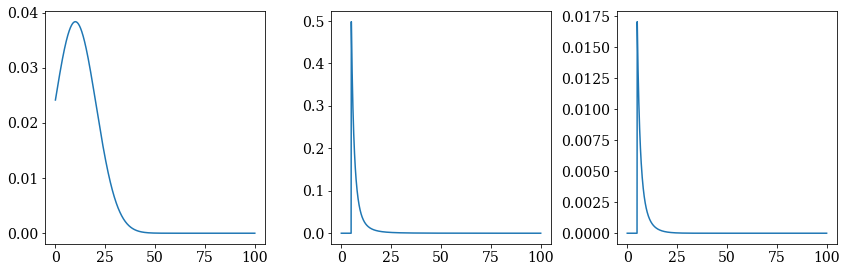

In [29]:
# Visualize the defined functions for sanity

m1_min=5
m1_max=100

m1 = np.linspace(0, m1_max, 1000)
mu = 10
sigma = 10.4
alpha=-3.5

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax1.plot(m1, normal_dist(m1, mu, sigma))
ax2.plot(m1, p_m1(m1, alpha, m1_min, m1_max))
# ax2.set_xlim(0, 20)
ax3.plot(m1, (normal_dist(m1, mu, sigma)*p_m1(m1, alpha, m1_min, m1_max)))


plt.tight_layout()
plt.show()


# Compute 1D Hyper posterior

## $\alpha$ hyper-posterior

In [139]:


def log_likelihood_alpha(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=30, \
        m1_min_int = 5., m1_max_int=200., n_m1_int=10000, \
        m1_min_pow = 5., m1_max_pow=200., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)
    
    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    log_p_alpha = np.zeros(n_alpha)

    posteriors = np.zeros((Nt, n_m1_int))

    for i in range(Nt):
        posteriors[i] = normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])

    for a in range(n_alpha):
        alpha = alpha_range[a]
        prior = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow)
        integrands = prior*posteriors
        integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
        
        integrals = integrals[integrals!=0]
        
        log_p_alpha[a] = np.sum(np.log(integrals))
        
    return log_p_alpha, alpha_range


### $\lambda$=0, alpha posterior

In [140]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [141]:
alpha_min = alpha_inj-0.25
alpha_max=alpha_inj+0.25
n_alpha=100

alpha_range_lam_0 = np.linspace(alpha_min, alpha_max, n_alpha)
# fname_alpha_lam_0 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_log_likelihoods_lam_0"    

In [142]:
log_p_alpha_lam_0_src, alpha_range_lam_0 = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_min_int = mmin_inj, m1_max_int=mmax_inj, n_m1_int=10000,\
    m1_min_pow = mmin_inj, m1_max_pow=mmax_inj,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_alpha_norm_lam_0 =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)

# Save likelihoods to file
# np.savetxt(fname_alpha_lam_0, log_alpha_norm_lam_0)


In [709]:
# Load likelihoods from file
# log_alpha_norm_lam_0 = np.loadtxt(fname_alpha_lam_0)

In [143]:
# Infer 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_alpha_norm_lam_0), alpha_range_lam_0
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

mu_alpha = popt[0]
sig_alpha = popt[1]
print(popt)

bias_sigma = ((mu_alpha - alpha_inj)/sig_alpha)
print(rf"Injected alpha is {bias_sigma :.2f} sigma away")

[-3.51149723 -0.0259497  -0.06512216]
Injected alpha is 0.44 sigma away


In [144]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm_lam_0, alpha_range_lam_0)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.5375420173416128, -3.511537600185994, -3.48562449496518
Injected alpha is -0.445 sigma away


most likely alpha (IN SOURCE FRAME) = -3.511497226533981


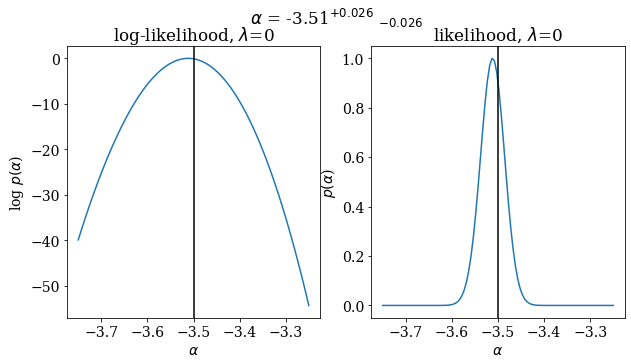

In [145]:
print("most likely alpha (IN SOURCE FRAME) =",mu_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_lam_0, log_alpha_norm_lam_0)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(alpha_range_lam_0, np.exp(log_alpha_norm_lam_0))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda$=1, alpha posterior

In [711]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True)

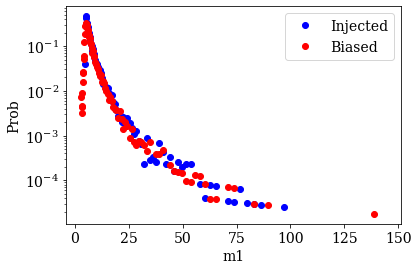

In [712]:
bins = np.geomspace(3, 150, 100)

m1_inj = df_mc["m1"] / (1+df_mc["z"])
y, X = np.histogram(m1_inj, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'bo', label='Injected')

y, X = np.histogram(m1_mu_sampled_biased, bins=bins, density=True)
X = X[:-1]
plt.plot(X, y, 'ro', label='Biased')

plt.xlabel("m1")
plt.ylabel("Prob")
plt.legend()

plt.semilogy()
plt.show()

From the Mathematica nb, a small increase in both Mc and eta results in lower m1, higher m2. The biased m1s are lower for high masses, which makes the power-law slope steeper.

In [713]:
alpha_min = alpha_inj-1.0
alpha_max=alpha_inj+0.50
n_alpha=100

alpha_range_lam_1 = np.linspace(alpha_min, alpha_max, n_alpha)
fname_alpha_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_log_likelihoods_lam_1"    

In [714]:
log_p_alpha_lam_1, alpha_range_lam_1 = log_likelihood_alpha(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_min_int = mmin_inj, m1_max_int=mmax_inj, n_m1_int=10000,\
    m1_min_pow = mmin_inj, m1_max_pow=mmax_inj,\
    Ns=len(m1_mu_sampled_biased), Nt=len(m1_mu_sampled_biased))

log_alpha_norm_lam_1 =log_p_alpha_lam_1 - np.max(log_p_alpha_lam_1)

# Save likelihoods to file
# np.savetxt(fname_alpha_lam_1, log_alpha_norm_lam_1)

In [723]:
# Load likelihoods from file
# log_alpha_norm_lam_1 = np.loadtxt(fname_alpha_lam_1)

In [724]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_alpha_norm_lam_1), alpha_range_lam_1
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

mu_alpha = popt[0]
sig_alpha = popt[1]
print(popt)

bias_sigma = ((mu_alpha - alpha_inj)/sig_alpha)
print(rf"Injected alpha is {bias_sigma :.2f} sigma away")

[-3.89577954  0.02982828  0.07488768]
Injected alpha is -13.27 sigma away


In [720]:
# 68% confidence interval using KDE
med_alpha, sig_pos_alpha, sig_neg_alpha = get_cofidence_int_1d(log_alpha_norm_lam_1, alpha_range_lam_1)

print(f"68% Confidence interval: {sig_neg_alpha}, {med_alpha}, {sig_pos_alpha}")
bias_sigma = (med_alpha-alpha_inj)/(sig_pos_alpha-med_alpha)
print(rf"Injected alpha is {bias_sigma:.3f} sigma away")


68% Confidence interval: -3.926754738158679, -3.8958890528558014, -3.865268222528915
Injected alpha is -12.929 sigma away


most likely alpha (IN SOURCE FRAME) = -3.8957795442539083


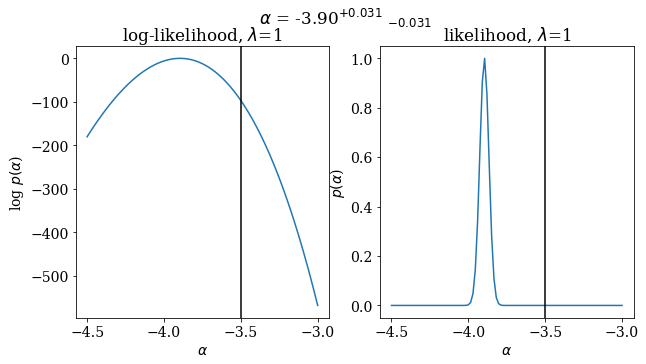

In [721]:
print("most likely alpha (IN SOURCE FRAME) =", mu_alpha)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(alpha_range_lam_1, log_alpha_norm_lam_1)
axes[0].axvline(x=alpha_inj, color='k')
axes[0].set_ylabel("log $p(\\alpha$)")
axes[0].set_xlabel("$\\alpha$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(alpha_range_lam_1, np.exp(log_alpha_norm_lam_1))
axes[1].axvline(x=alpha_inj, color='k')
axes[1].set_ylabel("$p(\\alpha$)")
axes[1].set_xlabel("$\\alpha$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"$\\alpha$ = {med_alpha:.2f}$^{{+{sig_pos_alpha-med_alpha:.3f}}}$ $_{{{sig_neg_alpha - med_alpha:.3f}}}$", y=0.99)
# plt.tight_layout()

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_alpha_{alpha_inj:.1f}_hyper_posterior_lam_1.pdf')
plt.show()

## m_min hyper-posterior

In [220]:
m1_low_min = 4.95
m1_low_max= 5.05
n_m1_low=50

m1_max_int=1000.0
n_m1_int = 1000

m1_min_pow = m1_low_max
m1_max_pow = mmax_inj

m1_low = 4.96
m1_int_range = np.geomspace(3.5, m1_max_int, n_m1_int)
prior = p_m1(m1_int_range, alpha, m1_low, m1_max_pow)
# prior = prior/integrate.trapezoid(prior, m1_int_range)

integrate.trapezoid(prior, m1_int_range)

1.0012821465247415

In [221]:
def log_likelihood_mmin(m1_mu_events, m1_sigma_events, \
    alpha=-3.5, \
    m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
    m1_max_int=200., n_m1_int=20000, \
    m1_max_pow=200., \
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    m1_min_int = m1_low_min

    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros(n_m1_low)

    m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)

    posteriors = np.zeros((Nt, n_m1_int))

    for i in range(Nt):
        posteriors[i] = normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])

    for m1_low_index in range(n_m1_low):
        m1_min_pow = m1_low_range[m1_low_index]
        
        prior = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow)
        # make sure the prior is normalized 
        # (becomes a problem with geomspaced bins where the first few numbers are 0s)
        prior = prior / integrate.trapezoid(prior, m1_int_range)

        integrands = prior*posteriors
        integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
            
        integrals = integrals[integrals!=0]
            
        log_likelihoods[m1_low_index] = np.sum(np.log(integrals))
        
    return log_likelihoods, m1_low_range


In [170]:
# def log_likelihood_mmin(m1_mu_events, m1_sigma_events, \
#     alpha=-3.5, \
#     m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
#     m1_max_int=200., n_m1_int=20000, \
#     m1_max_pow=200., \
#         Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
#     m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
#     log_likelihoods = np.zeros(n_m1_low)

#     for m1_low_index in range(n_m1_low):
#         m1_min_pow = m1_low_range[m1_low_index]
#         m1_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

#         total_int = 0

#         for i in range(Nt):
#             # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
#             # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
#             # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
#             integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
#             int_term = integrate.trapezoid(integrand, m1_int_range)
#             if int_term==0:
#                 int_term=1

#             total_int = total_int + np.log(Ns) + np.log(int_term)
            
#         log_likelihoods[m1_low_index] = -Ns + total_int
        
#     return log_likelihoods, m1_low_range


### $\lambda=0$, m_min posterior

In [164]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [230]:
m1_low_min = 4.95
m1_low_max= 5.05
n_m1_low=200

m1_low_range_lam_0 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
# fname_mmin_lam_0 = f"N_{len(m1_mu_sampled)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_0"    

In [231]:
log_p_mmin_lam_0, m1_low_range_lam_0 = log_likelihood_mmin(m1_mu_sampled, m1_sigma_events, \
    alpha=alpha_inj, \
    m1_low_min =m1_low_min, m1_low_max =m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=mmax_inj, n_m1_int=10000, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmin_norm_lam_0 =log_p_mmin_lam_0 - np.max(log_p_mmin_lam_0)

# Save likelihoods to file
# np.savetxt(fname_mmin_lam_0, log_mmin_norm_lam_0)

In [733]:
# Load likelihoods from file
# log_mmin_norm_lam_0 = np.loadtxt(fname_mmin_lam_0)

In [235]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmin_norm_lam_0), m1_low_range_lam_0
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[5.0, 0.6, 1.0])

mu_mmin = popt[0]
sig_mmin = popt[1]
print(popt)

bias_sigma = ((mu_mmin - mmin_inj)/sig_mmin)
print(rf"Injected m1_min is {bias_sigma :.2f} sigma away")

[ 4.9994355  -0.00685494 -0.01724307]
Injected m1_min is 0.08 sigma away


In [236]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_0, m1_low_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 4.992518749265602, 4.999440911639079, 5.00619668267835
Injected mmin is -0.083 sigma away


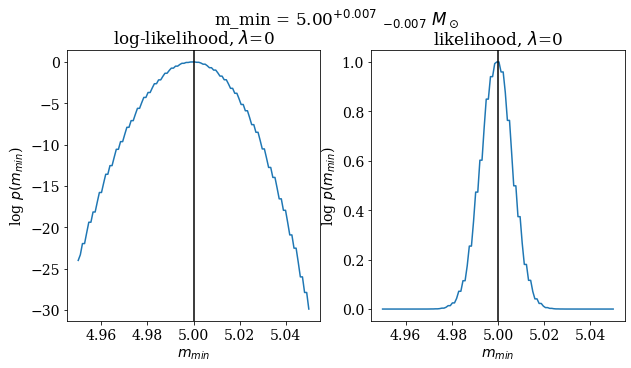

In [237]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_0, log_mmin_norm_lam_0)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_low_range_lam_0, np.exp(log_mmin_norm_lam_0))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("log $p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmin_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, m_min posterior

In [737]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True)

In [738]:
m1_low_min = 4.5
m1_low_max= 4.75
n_m1_low=80

m1_low_range_lam_1 = np.linspace(m1_low_min, m1_low_max, n_m1_low)
fname_mmin_lam_1 = f"N_{len(m1_mu_sampled)}_mmin_{m1_low_min:.2f}_{m1_low_max:.2f}_n_{n_m1_low:.0f}_log_likelihoods_lam_1"    

In [739]:
log_p_mmin_lam_1, m1_low_range_lam_1 = log_likelihood_mmin(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha=alpha_inj, \
    m1_low_min =m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=mmax_inj, n_m1_int=20000, \
    m1_max_pow=mmax_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmin_norm_lam_1 =log_p_mmin_lam_1 - np.max(log_p_mmin_lam_1)

# Save likelihoods to file
np.savetxt(fname_mmin_lam_1, log_mmin_norm_lam_1)

In [740]:
# Load likelihoods from file
log_mmin_norm_lam_1 = np.loadtxt(fname_mmin_lam_1)

In [743]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmin_norm_lam_1), m1_low_range_lam_1
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[5.0, 0.6, 1.0])

mu_mmin = popt[0]
sig_mmin = popt[1]
print(popt)

bias_sigma = ((mu_mmin - mmin_inj)/sig_mmin)
print(rf"Injected m1_min is {bias_sigma :.2f} sigma away")

[4.61700959 0.00757813 0.01755624]
Injected m1_min is -50.54 sigma away


In [744]:
# 68% confidence interval using KDE
med_mmin, sig_pos_mmin, sig_neg_mmin = get_cofidence_int_1d(log_mmin_norm_lam_1, m1_low_range_lam_1)

print(f"68% Confidence interval: {sig_neg_mmin}, {med_mmin}, {sig_pos_mmin}")
bias_sigma = (med_mmin-mmin_inj)/(sig_pos_mmin-med_mmin)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 4.609101580133945, 4.616977387777981, 4.6248421692446176
Injected mmin is -48.701 sigma away


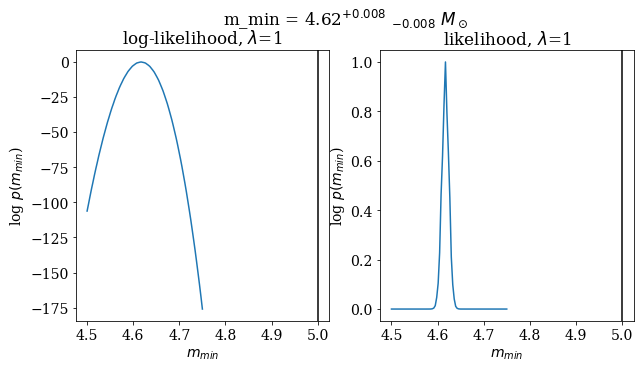

In [745]:
# print("most likely m1_min (IN SOURCE FRAME) =",mu_mmin)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_lam_1, log_mmin_norm_lam_1)
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log $p(m_{min}$)")
axes[0].set_xlabel("$m_{min}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_low_range_lam_1, np.exp(log_mmin_norm_lam_1))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("log $p(m_{min}$)")
axes[1].set_xlabel("$m_{min}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_min = {med_mmin:.2f}$^{{+{sig_pos_mmin-med_mmin:.3f}}}$ $_{{{sig_neg_mmin - med_mmin:.3f}}} \,\, M_\odot$", y=1.0)
plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmin_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

## m_max hyper-posterior

In [31]:
def log_likelihood_mmax(m1_mu_events, m1_sigma_events, \
    alpha=alpha_inj, \
    m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
    m1_min_int=5., m1_max_int=100., n_m1_int=20000, \
    m1_min_pow=5., \
    Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):
    
    # m1_max_int=m1_high_max
    
    m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)
    log_likelihoods = np.zeros(n_m1_high)

    m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)

    for m1_high_index in range(n_m1_high):
        m1_max_pow = m1_high_range[m1_high_index]

        total_int = 0

        for i in range(Nt):
            # Need to set the integral to 1, s.t. log(1) = 0, if posterior is very far from the data and returns log(0) = -inf
            
            # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
            # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
            integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
            int_term = integrate.trapezoid(integrand, m1_int_range)
            if int_term==0:
                int_term=1
            
            total_int = total_int + np.log(Ns) + np.log(int_term)
            
        log_likelihoods[m1_high_index] = -Ns + total_int
        
    return log_likelihoods, m1_high_range

### $\lambda=0$, m_max posterior

In [32]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [33]:
m1_high_min = 40.
m1_high_max= 100.
n_m1_high=20

m1_high_range_lam_0 = np.linspace(m1_high_min, m1_high_max, n_m1_high)
# fname_mmax_lam_0 = f"N_{len(m1_mu_sampled)}_mmax_{m1_high_min:.2f}_{m1_high_max:.2f}_n_{n_m1_high:.0f}_log_likelihoods_lam_0"    

In [34]:
log_p_mmax_lam_0, m1_high_range_lam_0 = log_likelihood_mmax(m1_mu_sampled, m1_sigma_events, \
    alpha=alpha_inj,
    m1_high_min =m1_high_min, m1_high_max =m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=mmin_inj, n_m1_int=10000, \
    m1_min_pow=mmin_inj, \
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
    
log_mmax_norm_lam_0 =log_p_mmax_lam_0 - np.max(log_p_mmax_lam_0)

# # Save likelihoods to file
# np.savetxt(fname_mmax_lam_0, log_mmax_norm_lam_0)

In [750]:
# # Load likelihoods from file
# log_mmax_norm_lam_0 = np.loadtxt(fname_mmax_lam_0)

In [37]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmax_norm_lam_0), m1_high_range_lam_0
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[60., 0.6, 1.0])

mu_mmax = popt[0]
sig_mmax = popt[1]
print(popt)

bias_sigma = ((mu_mmax - mmax_inj)/sig_mmax)
print(rf"Injected m1_max is {bias_sigma :.2f} sigma away")

[57.39627861  1.81805249  6.6003573 ]
Injected m1_max is -1.43 sigma away


In [38]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm_lam_0, m1_high_range_lam_0)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 54.77584720086884, 57.54912404719661, 60.518463577652525
Injected mmin is -0.825 sigma away


most likely m1_max (IN SOURCE FRAME) = 57.396278614749164


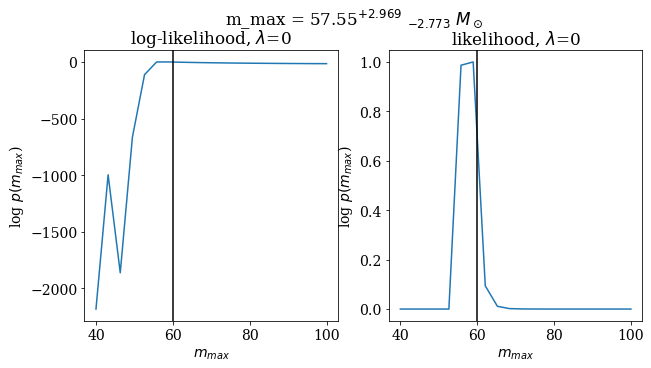

In [39]:
print("most likely m1_max (IN SOURCE FRAME) =",mu_mmax)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_lam_0, log_mmax_norm_lam_0)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=0")

axes[1].plot(m1_high_range_lam_0, np.exp(log_mmax_norm_lam_0))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=0")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)
plt.tight_layout

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_0.pdf')
plt.show()

### $\lambda=1$, m_max posterior

In [40]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled_biased, m1_sigma_events_biased = sample_m1_events(df_mc, df_eta, biased=True)

[ 57.11098457  50.12522025  50.55380187  51.77108278 164.77119811
  53.2897815   53.65342785 104.08184505  69.58392161  69.0223979
  52.29236863  58.63339053]


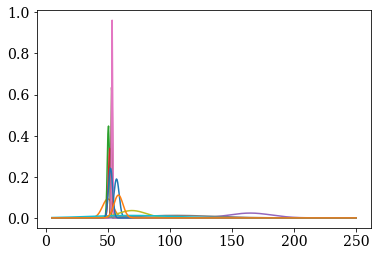

In [58]:
mask = (m1_mu_sampled_biased>50)
print((m1_mu_sampled_biased)[mask])
# df_mc[mask]["bias_19"]/ (df_mc[mask]["z"]+1)
# df_mc[mask]["Mc_stat_err"]
# df_mc[mask]

m1 = np.linspace(5, 250, 500)
for i in range(np.sum(mask)):
    m1_mu = m1_mu_sampled_biased[mask][i]
    m1_sig = m1_sigma_events_biased[mask][i]
    plt.plot(m1, stats.norm.pdf(m1, loc=m1_mu, scale=m1_sig))

In [50]:
np.max(m1_mu_sampled_biased)

164.77119811062468

In [51]:
m1_high_min = 40.
m1_high_max= 200.
n_m1_high=30

m1_high_range_lam_1 = np.linspace(m1_high_min, m1_high_max, n_m1_high)
# fname_mmax_lam_1 = f"N_{len(m1_mu_sampled)}_mmax_{m1_high_min:.2f}_{m1_high_max:.2f}_n_{n_m1_high:.0f}_log_likelihoods_lam_1"    

In [52]:
log_p_mmax_lam_1, m1_high_range_lam_1 = log_likelihood_mmax(m1_mu_sampled_biased, m1_sigma_events_biased, \
    alpha=alpha_inj,
    m1_high_min=m1_high_min, m1_high_max=m1_high_max, n_m1_high=n_m1_high,\
    m1_min_int=mmin_inj, m1_max_int=300., n_m1_int=10000, \
    m1_min_pow=mmin_inj, \
    Ns=len(m1_mu_sampled_biased), Nt=len(m1_mu_sampled_biased))
    
    
log_mmax_norm_lam_1 =log_p_mmax_lam_1 - np.max(log_p_mmax_lam_1)

# # Save likelihoods to file
# np.savetxt(fname_mmax_lam_1, log_mmax_norm_lam_1)

In [761]:
# # Load likelihoods from file
# log_mmax_norm_lam_1 = np.loadtxt(fname_mmax_lam_1)

In [53]:
# 68% confidence interval assuming Normal Distribution
target_func = normal_dist
y, X = np.exp(log_mmax_norm_lam_1), m1_high_range_lam_1
popt, pcov = optimize.curve_fit(target_func, X, y, p0=[60., 0.6, 1.0])

mu_mmax = popt[0]
sig_mmax = popt[1]
print(popt)

bias_sigma = ((mu_mmax - mmax_inj)/sig_mmax)
print(rf"Injected m1_max is {bias_sigma :.2f} sigma away")

[176.14228563  29.66247303  76.0722863 ]
Injected m1_max is 3.92 sigma away


In [54]:
med_mmax, sig_pos_mmax, sig_neg_mmax = get_cofidence_int_1d(log_mmax_norm_lam_1, m1_high_range_lam_1)

print(f"68% Confidence interval: {sig_neg_mmax}, {med_mmax}, {sig_pos_mmax}")
bias_sigma = (med_mmax-mmax_inj)/(sig_pos_mmax-med_mmax)
print(rf"Injected mmin is {bias_sigma:.3f} sigma away")


68% Confidence interval: 130.44893350922803, 164.7294916172903, 187.75977369562267
Injected mmin is 4.547 sigma away


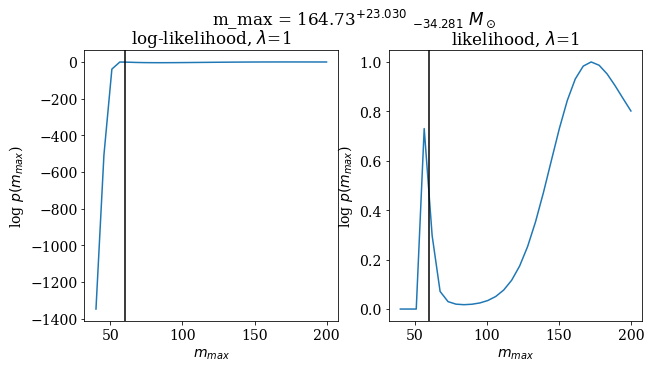

In [56]:
# print(f"most likely m1_max (IN SOURCE FRAME) = {m1_high_range_lam_1[np.argmax(log_mmax_norm_lam_1)]:.3f}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_lam_1, log_mmax_norm_lam_1)
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log $p(m_{max}$)")
axes[0].set_xlabel("$m_{max}$")
axes[0].set_title("log-likelihood, $\lambda$=1")

axes[1].plot(m1_high_range_lam_1, np.exp(log_mmax_norm_lam_1))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("log $p(m_{max}$)")
axes[1].set_xlabel("$m_{max}$")
axes[1].set_title("likelihood, $\lambda$=1")

plt.suptitle(f"m_max = {med_mmax:.2f}$^{{+{sig_pos_mmax-med_mmax:.3f}}}$ $_{{{sig_neg_mmax - med_mmax:.3f}}} \,\, M_\odot$", y=1.0)

# plt.savefig(plotdir+f'N_{len(m1_mu_sampled)}_mmax_hyper_posterior_lam_1.pdf')
plt.tight_layout

plt.show()

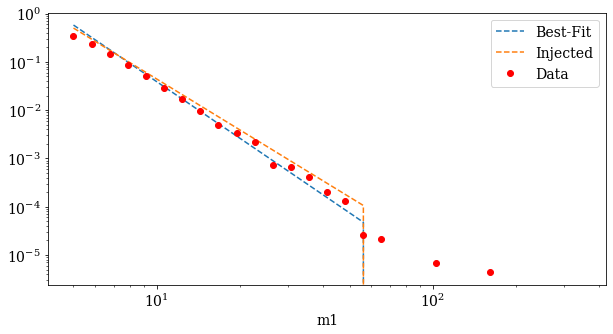

In [49]:
bins = np.geomspace(5, 400, 30)

y, X = np.histogram(m1_mu_sampled_biased, bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()



plt.figure(figsize=(10, 5))
plt.plot(X, p_m1(X,  -3.89, 5, 60), '--', label='Best-Fit')
# plt.plot(X, p_m1(X,  -3.89, 5, 60), '--', label='Best-Fit 2')

plt.plot(X, p_m1(X,  alpha_inj, 5, mmax_inj), '--', label='Injected')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(30, 70)

plt.show()

# 2D inference (Manual)

## alpha, m1_max

In [381]:
def log_likelihood_alpha_m1max(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=10, \
        m1_high_min = 93.0, m1_high_max = 107., n_m1_high=10,\
        m1_min_int=5., n_m1_int=20000, \
        m1_min_pow=5., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    m1_max_int=m1_high_max

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_high_range = np.linspace(m1_high_min, m1_high_max, n_m1_high)

    log_likelihoods = np.zeros((n_m1_high, n_alpha))

    for m1_high_index in range(n_m1_high):
        m1_max_pow = m1_high_range[m1_high_index]

        m1_int_range = np.linspace(m1_min_int, m1_max_int, n_m1_int)
        
        for a in range(n_alpha):
            
            alpha = alpha_range[a]
            total_int = 0

            for i in range(Nt):
                # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
                # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
                # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
                integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
                int_term = integrate.trapezoid(integrand, m1_int_range)
                if int_term==0:
                    int_term=1
                    
                total_int = total_int + np.log(Ns) + np.log(int_term)
                
            log_likelihoods[m1_high_index, a] = -Ns + total_int
        
        
           
    return log_likelihoods, alpha_range, m1_high_range

### $\lambda=0$

In [38]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [768]:
alpha_min = alpha_inj-0.25
alpha_max=alpha_inj+0.25
n_alpha=50
m1_high_min = 80.0
m1_high_max = 180.0
n_m1_high=50

alpha_range_a_mmax = np.linspace(alpha_min, alpha_max, n_alpha)
m1_high_range_a_mmax = np.linspace(m1_high_min, m1_high_max, n_m1_high)

fname_alpha_mmax = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_log_likelihoods"    


In [40]:
# log_likelihoods_a_mmax, alpha_range_a_mmax, m1_high_range_a_mmax = log_likelihood_alpha_m1max(m1_mu_sampled, m1_sigma_events, \
#     alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
#     m1_high_min = m1_high_min, m1_high_max = m1_high_max, n_m1_high=n_m1_high,\
#     m1_min_int=5., n_m1_int=10000, \
#     m1_min_pow=5.,\
#     Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))

# log_likelihoods_norm_a_mmax = log_likelihoods_a_mmax - np.max(log_likelihoods_a_mmax)
    

In [42]:
# # Save likelihoods to file
# np.savetxt(fname_alpha_mmax, log_likelihoods_norm_a_mmax)

In [769]:
# Load likelihoods from file
log_likelihoods_norm_a_mmax = np.loadtxt(fname_alpha_mmax)

In [770]:
index_max = np.argmax(log_likelihoods_norm_a_mmax)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmax.shape)

print(index_max)
m_max_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmax[alpha_index_2d])
print("m1_max:", m1_high_range_a_mmax[m_max_index_2d])

(8, 24)
alpha: -3.5051020408163267
m1_max: 96.3265306122449


In [771]:
def sample(function, alpha_min=-3.7, alpha_max=-3.3, m1_min=80., m1_max=180., n_samples=10):
    alphas = np.zeros(n_samples)
    m1s = np.zeros(n_samples)
    for i in range(n_samples):
        found = False
        while not found:
            x = np.random.uniform(low=alpha_min, high=alpha_max)
            y = np.random.uniform(low=m1_min, high=m1_max)
            z = np.random.uniform(low=0.0, high=1.0)
            if z < function(x,y):
                found = True
        alphas[i] = x
        m1s[i] = y
    
    return alphas, m1s

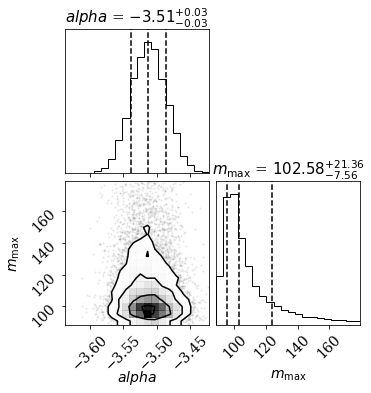

In [773]:
# 68% confidence interval using KDE

likelihood_interp = interpolate.interp2d(alpha_range_a_mmax, m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax))

nsamples=10000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-3.7, alpha_max=-3.3,\
                               m1_min=80., m1_max=180., \
                                n_samples=nsamples)

samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm max}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmax_joint_likelihood_contours_lam_0.pdf")


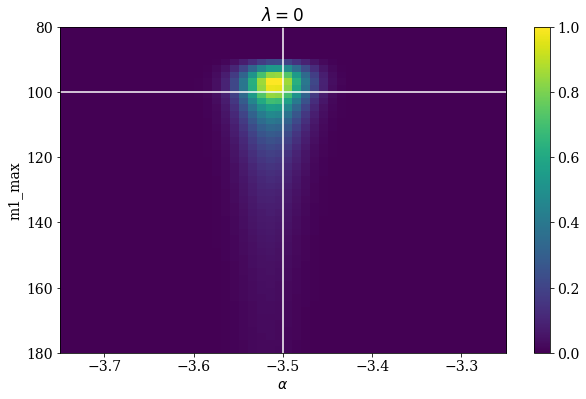

In [414]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.imshow((log_likelihoods_norm_a_mmax), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmax), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])

plt.colorbar()

plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmax_inj, color='w')

plt.xlabel("$\\alpha$")
plt.ylabel("m1_max")
plt.title("$\lambda=0$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_LOG.pdf")
# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_EXP.pdf")
plt.show()
    


most likely m_max (IN SOURCE FRAME) = 96.3265306122449


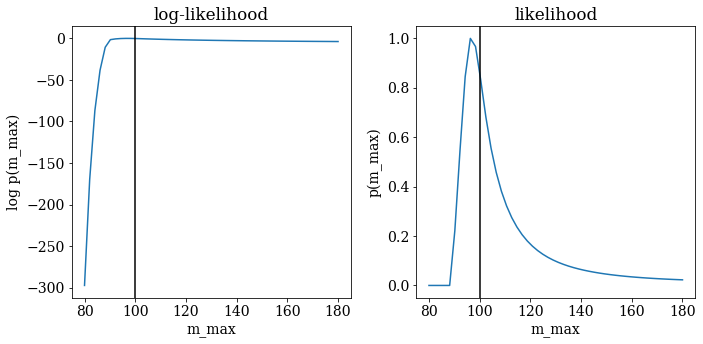

In [45]:
print("most likely m_max (IN SOURCE FRAME) =",m1_high_range_a_mmax[np.argmax(log_likelihoods_norm_a_mmax[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_a_mmax, log_likelihoods_norm_a_mmax[:,alpha_index_2d])
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log p(m_max)")
axes[0].set_xlabel("m_max")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax[:,alpha_index_2d]))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("p(m_max)")
axes[1].set_xlabel("m_max")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

### $\lambda=1$

In [670]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True)

In [786]:
alpha_min = alpha_inj-0.7
alpha_max=alpha_inj
n_alpha=50
m1_high_min = 70.0
m1_high_max = 500.0
n_m1_high=50

alpha_range_a_mmax = np.linspace(alpha_min, alpha_max, n_alpha)
m1_high_range_a_mmax = np.linspace(m1_high_min, m1_high_max, n_m1_high)

fname_alpha_mmax_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lambda_1_log_likelihoods"    


In [31]:
# log_likelihoods_a_mmax_lam_1, alpha_range_a_mmax, m1_high_range_a_mmax = log_likelihood_alpha_m1max(m1_mu_sampled, m1_sigma_events, \
#     alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
#     m1_high_min = m1_high_min, m1_high_max = m1_high_max, n_m1_high=n_m1_high,\
#     m1_min_int=5., n_m1_int=10000, \
#     m1_min_pow=5.,\
#     Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))

# log_likelihoods_norm_a_mmax_lam_1 = log_likelihoods_a_mmax_lam_1 - np.max(log_likelihoods_a_mmax_lam_1)
    

In [32]:
# np.savetxt(fname_alpha_mmax_lam_1, log_likelihoods_norm_a_mmax_lam_1)

In [787]:
log_likelihoods_norm_a_mmax_lam_1 = np.loadtxt(fname_alpha_mmax_lam_1)

In [788]:
index_max = np.argmax(log_likelihoods_norm_a_mmax_lam_1)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmax_lam_1.shape)

print(index_max)
m_max_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmax[alpha_index_2d])
print("m1_max:", m1_high_range_a_mmax[m_max_index_2d])

(7, 18)
alpha: -3.942857142857143
m1_max: 131.42857142857142


In [789]:
likelihood_interp = interpolate.interp2d(alpha_range_a_mmax, m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax_lam_1))

nsamples=50000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-4.0, alpha_max=-3.6,\
                               m1_min=80., m1_max=280., \
                                n_samples=nsamples)

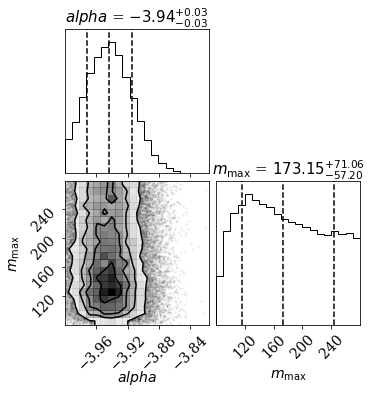

In [790]:
samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm max}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmax_joint_likelihood_contours_lam_1.pdf")

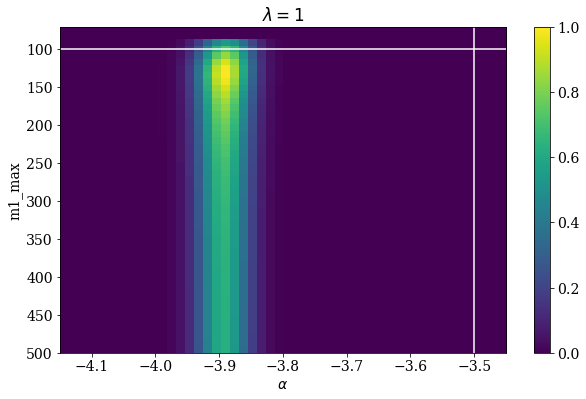

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
# plt.imshow((log_likelihoods_norm_a_mmax_lam_1), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmax_lam_1), aspect='auto', extent=[alpha_range_a_mmax[0], alpha_range_a_mmax[-1], m1_high_range_a_mmax[-1], m1_high_range_a_mmax[0]])

plt.colorbar()

plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmax_inj, color='w')

plt.xlabel("$\\alpha$")
plt.ylabel("m1_max")
plt.title("$\lambda=1$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lam_1_LOG.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmax_{m1_high_min:.0f}_{m1_high_max:.0f}_n_{n_m1_high:.0f}_lam_1_EXP.pdf")
plt.show()
    


most likely m_max (IN SOURCE FRAME) = 131.42857142857142


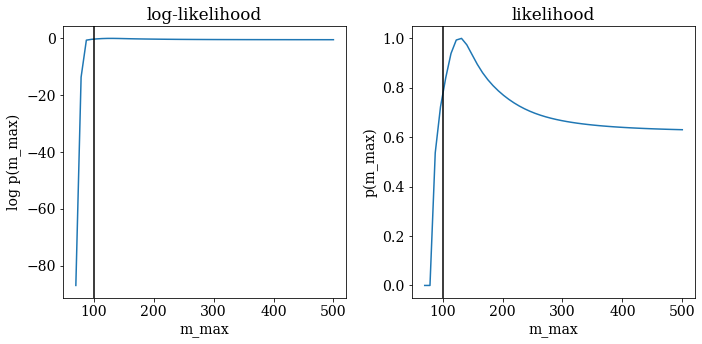

In [39]:
print("most likely m_max (IN SOURCE FRAME) =",m1_high_range_a_mmax[np.argmax(log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_high_range_a_mmax, log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d])
axes[0].axvline(x=mmax_inj, color='k')
axes[0].set_ylabel("log p(m_max)")
axes[0].set_xlabel("m_max")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_high_range_a_mmax, np.exp(log_likelihoods_norm_a_mmax_lam_1[:,alpha_index_2d]))
axes[1].axvline(x=mmax_inj, color='k')
axes[1].set_ylabel("p(m_max)")
axes[1].set_xlabel("m_max")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

# alpha, m1_min

In [49]:
def log_likelihood_alpha_m1min(m1_mu_events, m1_sigma_events, \
    alpha_min=-4.5, alpha_max=-3, n_alpha=50, \
        m1_low_min = 3.0, m1_low_max = 7.0, n_m1_low=50,\
        m1_max_int=200., n_m1_int=20000, \
        m1_max_pow=200., \
            Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"])):

    alpha_range = np.linspace(alpha_min, alpha_max, n_alpha)
    m1_low_range = np.linspace(m1_low_min, m1_low_max, n_m1_low)
    log_likelihoods = np.zeros((n_m1_low, n_alpha))

    for m1_low_index in range(n_m1_low):
        m1_min_pow = m1_low_range[m1_low_index]
        m1_int_range = np.geomspace(m1_min_pow, m1_max_int, n_m1_int)

        for a in range(n_alpha):
            
            alpha = alpha_range[a]
            total_int = 0

            for i in range(Nt):
                # Need to set the integral to zero if posterior is very far from the data and returns log(0) = -inf
                # DO NOT USE TRUNCATED GAUSSIAN for the posterior if m_min, m_max will vary from integral to integral. 
                # This introduces a limit-dependent integrand that can artificially inflate the hyperposterior in one direction endlessly
                integrand = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow) * normal_dist(m1_int_range, m1_mu_events[i], m1_sigma_events[i])
                int_term = integrate.trapezoid(integrand, m1_int_range)

                if int_term==0:
                    int_term=1
                    
                total_int = total_int + np.log(Ns) + np.log(int_term)
                
            log_likelihoods[m1_low_index, a] = -Ns + total_int
        
        
           
    return log_likelihoods, alpha_range, m1_low_range

### $\lambda=0$

In [14]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=False)

In [774]:
alpha_min = alpha_inj-0.25
alpha_max = alpha_inj+0.25
n_alpha = 50
m1_low_min = mmin_inj-0.05
m1_low_max = mmin_inj+0.05
n_m1_low= 50

alpha_range_a_mmin = np.linspace(alpha_min, alpha_max, n_alpha)
m1_low_range_a_mmin = np.linspace(m1_low_min, m1_low_max, n_m1_low)

fname_alpha_mmin = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_log_likelihoods" 


In [16]:
log_likelihoods_norm_a_mmin, alpha_range_a_mmin, m1_low_range_a_mmin = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=100., n_m1_int=10000, \
    m1_max_pow=100.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_likelihoods_norm_a_mmin = log_likelihoods_norm_a_mmin - np.max(log_likelihoods_norm_a_mmin)

In [22]:
# np.savetxt(fname_alpha_mmin, log_likelihoods_norm_a_mmin)

In [775]:
log_likelihoods_norm_a_mmin = np.loadtxt(fname_alpha_mmin)

In [776]:
index_max = np.argmax(log_likelihoods_norm_a_mmin)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmin.shape)

m_min_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmin[alpha_index_2d])
print("m1_min:", m1_low_range_a_mmin[m_min_index_2d])

index_max

alpha: -3.5051020408163267
m1_min: 4.996938775510204


(23, 24)

In [777]:
likelihood_interp = interpolate.interp2d(alpha_range_a_mmin, m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin))

nsamples=50000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-3.4, alpha_max=-3.6,\
                               m1_min=4.95, m1_max=5.05, \
                                n_samples=nsamples)

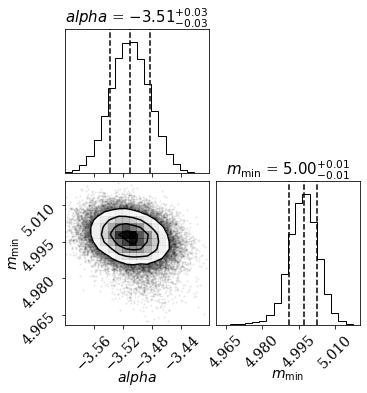

In [778]:
samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm min}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

# plt.savefig(plotdir+ "alpha_mmin_joint_likelihood_contours_lam_0.pdf")

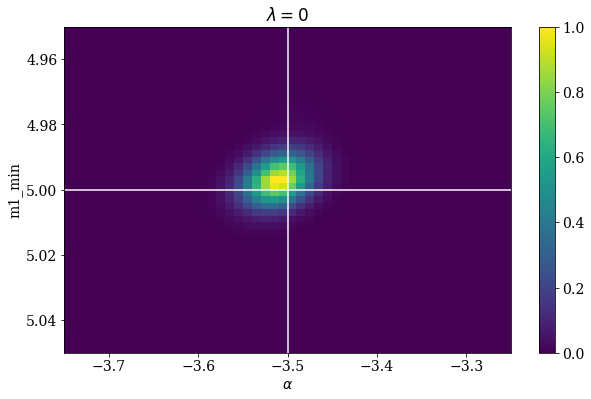

In [113]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.imshow((log_likelihoods_norm_a_mmin), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmin), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])


plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmin_inj, color='w')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")
plt.title("$\lambda=0$")

# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_LOG.pdf")
plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_EXP.pdf")
plt.show()
    
# 

most likely m_min (IN SOURCE FRAME) = 4.996938775510204


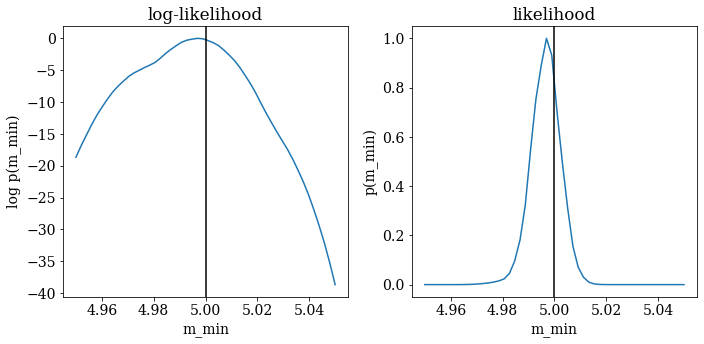

In [26]:
print("most likely m_min (IN SOURCE FRAME) =",m1_low_range_a_mmin[np.argmax(log_likelihoods_norm_a_mmin[:,alpha_index_2d])])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(m1_low_range_a_mmin, log_likelihoods_norm_a_mmin[:,alpha_index_2d])
axes[0].axvline(x=mmin_inj, color='k')
axes[0].set_ylabel("log p(m_min)")
axes[0].set_xlabel("m_min")
axes[0].set_title("log-likelihood")

axes[1].plot(m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin[:,alpha_index_2d]))
axes[1].axvline(x=mmin_inj, color='k')
axes[1].set_ylabel("p(m_min)")
axes[1].set_xlabel("m_min")
axes[1].set_title("likelihood")

plt.tight_layout()
plt.show()

### $\lambda=1$

In [51]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc, df_eta, biased=True)

In [779]:
alpha_min = alpha_inj-0.25
alpha_max = alpha_inj+0.25
n_alpha = 50
m1_low_min = mmin_inj-0.50
m1_low_max = mmin_inj+0.05
n_m1_low= 50

alpha_range_a_mmin = np.linspace(alpha_min, alpha_max, n_alpha)
m1_low_range_a_mmin = np.linspace(m1_low_min, m1_low_max, n_m1_low)

fname_alpha_mmin_lam_1 = f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_lambda_1_log_likelihoods" 


In [53]:
log_likelihoods_norm_a_mmin_lam_1, alpha_range_a_mmin, m1_low_range_a_mmin = log_likelihood_alpha_m1min(m1_mu_sampled, m1_sigma_events, \
    alpha_min=alpha_min, alpha_max=alpha_max, n_alpha=n_alpha, \
    m1_low_min=m1_low_min, m1_low_max=m1_low_max, n_m1_low=n_m1_low,\
    m1_max_int=100., n_m1_int=10000, \
    m1_max_pow=100.,\
    Ns=len(m1_mu_sampled), Nt=len(m1_mu_sampled))
    
log_likelihoods_norm_a_mmin_lam_1 = log_likelihoods_norm_a_mmin_lam_1 - np.max(log_likelihoods_norm_a_mmin_lam_1)

In [64]:
# np.savetxt(fname_alpha_mmin_lam_1, log_likelihoods_norm_a_mmin_lam_1)

In [780]:
log_likelihoods_norm_a_mmin_lam_1 = np.loadtxt(fname_alpha_mmin_lam_1)

In [781]:
index_max = np.argmax(log_likelihoods_norm_a_mmin_lam_1)
index_max = np.unravel_index(index_max, log_likelihoods_norm_a_mmin_lam_1.shape)

m_min_index_2d = index_max[0]
alpha_index_2d = index_max[1]

print("alpha:", alpha_range_a_mmin[alpha_index_2d])
print("m1_min:", m1_low_range_a_mmin[m_min_index_2d])

index_max

alpha: -3.4030612244897958
m1_min: 4.612244897959184


(10, 34)

In [783]:
likelihood_interp = interpolate.interp2d(alpha_range_a_mmin, m1_low_range_a_mmin, np.exp(log_likelihoods_norm_a_mmin_lam_1))

nsamples=50000
a_samples, m_samples = sample(likelihood_interp, \
                              alpha_min=-3.5, alpha_max=-3.3,\
                               m1_min=4.5, m1_max=4.7, \
                                n_samples=nsamples)

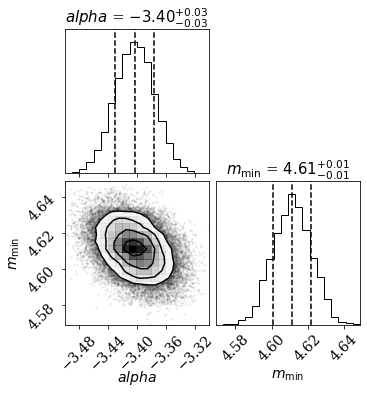

In [784]:
samples = np.vstack((a_samples, m_samples)).T

figure = corner.corner(samples,labels=[
        r"$alpha$",
        r"$m_{\rm min}$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 15},)

plt.savefig(plotdir+ "alpha_mmin_joint_likelihood_contours_lam_1.pdf")

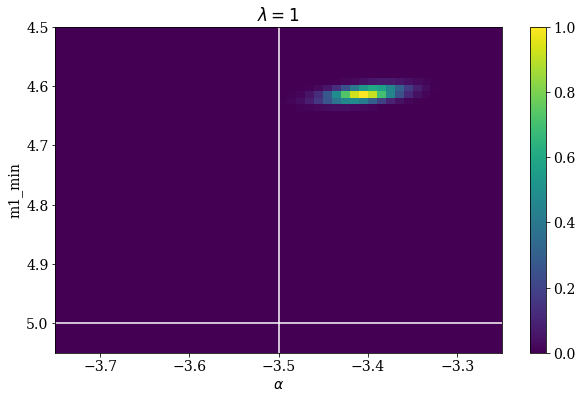

In [785]:
fig, ax = plt.subplots(figsize=(10, 6))

# plt.imshow((log_likelihoods_norm_a_mmin_lam_1), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])
plt.imshow(np.exp(log_likelihoods_norm_a_mmin_lam_1), aspect='auto', extent=[alpha_range_a_mmin[0], alpha_range_a_mmin[-1], m1_low_range_a_mmin[-1], m1_low_range_a_mmin[0]])


plt.axvline(x=alpha_inj, color='w')
plt.axhline(y=mmin_inj, color='w')

plt.colorbar()
plt.xlabel("$\\alpha$")
plt.ylabel("m1_min")
plt.title("$\lambda=1$")


# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_LOG_lam_1.pdf")
# plt.savefig(plotdir+f"N_{len(m1_mu_sampled)}_alpha_{alpha_min:.1f}_{alpha_max:.1f}_n_{n_alpha:.0f}_mmin_{m1_low_min:.0f}_{m1_low_max:.0f}_n_{n_m1_low:.0f}_EXP_lam_1.pdf")
plt.show()
    
# 

# Alpha Bias vs N_det

In [ ]:
def get_avg_sigma_boot(n_samples, n_bootstrap):

    n_samples = int(n_samples)

    sigma_devs_boot = np.zeros(n_bootstrap)

    for n in range(n_bootstrap):
        
        sample_indices = np.random.randint(0, len(df_mc_raw), n_samples)
        df_mc = df_mc_raw.iloc[sample_indices]
        df_eta = df_eta_raw.iloc[sample_indices]

        # Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
        z = df_mc["z"]
        mchirp = (df_mc["Mc"])/ (1+z)
        eta = df_mc["eta"]

        sigMc_raw = df_mc["Mc_stat_err"]
        sigEta = df_eta["eta_stat_err"]
        sigZ = df_mc["z_stat_err"]

        sigMc = np.sqrt((((mchirp**2)*((sigZ**2)*((1.+z)**-4.)))+((sigMc_raw**2)*((1.+z)**-2.))))


        aux0=0.25*((((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((mchirp**2)*(sigZ**2))))
        aux1=(((0.3*((1.+(-4.*eta))**0.5))+((0.3*((1.+(-4.*eta))**1.))+(1.*eta)))**2)
        aux2=(((1.+((1.+(-4.*eta))**0.5))**2))*((eta**2)*((sigMc_raw**2)*(((1.+z)**2))))
        aux3=(((1.+(-4.*eta))**-1.)*(aux1*((mchirp**2)*((sigEta**2)*(((1.+z)**2))))))+(0.25*aux2)
        m1_sigma_events=np.sqrt(((eta**-3.2)*(((1.+z)**-4.)*(aux0+aux3))))
        m1_sigma_events = m1_sigma_events.values


        # Use biased mc, eta for the m1_mu list only
        bias_eta = df_eta["bias_19"]
        bias_mc = df_mc["bias_19"]

        mchirp = (df_mc["Mc"] + bias_mc)
        eta = np.minimum(df_mc["eta"]+bias_eta, 0.25) # make sure that eta doesn't exceed what is physically possible

        m1_biased = conv.mass1_from_mchirp_eta(mchirp, eta)
        m1_mu_detections = m1_biased / (1+z)
        # sample mu from the detection gaussians to avoid Biases
        m1_mu_sampled = np.random.normal(m1_mu_detections, m1_sigma_events)

        log_p_alpha_lam_0_src, alpha_range_src = log_likelihood_alpha(m1_mu_sampled, m1_sigma_events, \
        alpha_min=alpha_inj-1.0, alpha_max=alpha_inj+0.5, n_alpha=30, \
        m1_min_int = 5., m1_max_int=200., n_m1_int=20000,\
        m1_min_pow = 5., m1_max_pow=100.,\
        Ns=len(df_mc["Mc"]), Nt=len(df_mc["Mc"]))
        log_alpha_norm =log_p_alpha_lam_0_src - np.max(log_p_alpha_lam_0_src)   


        target_func = normal_dist
        y, X = np.exp(log_alpha_norm), alpha_range_src
        popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 0.6, 1.0])

        mu_alpha = popt[0]
        sig_alpha = popt[1]
        sigma_devs_boot[n] = np.abs(alpha_inj - mu_alpha)/sig_alpha
        # print(rf"Injected alpha is {sigma_devs_boot[n] :.2f} sigma away")

    print(rf"For N = {n_samples} detections, injected alpha is {np.average(sigma_devs_boot) :.2f} sigma away on avg.")
    return np.median(sigma_devs_boot), np.std(sigma_devs_boot)

In [ ]:
N_samples_range = [10., 25., 50., 100., 150.]
med_sigma_boot_range = np.zeros(len(N_samples_range))
std_sigma_boot_range = np.zeros(len(N_samples_range))

In [ ]:
med_sigma_boot_range[0], std_sigma_boot_range[0] = get_avg_sigma_boot(n_samples=N_samples_range[0], n_bootstrap=100)

For N = 10 detections, injected alpha is 0.82 sigma away on avg.


In [ ]:
med_sigma_boot_range[1], std_sigma_boot_range[1] = get_avg_sigma_boot(n_samples=N_samples_range[1], n_bootstrap=100)

For N = 25 detections, injected alpha is 0.99 sigma away on avg.


In [ ]:
med_sigma_boot_range[2], std_sigma_boot_range[2] = get_avg_sigma_boot(n_samples=N_samples_range[2], n_bootstrap=100)

For N = 50 detections, injected alpha is 1.18 sigma away on avg.


In [ ]:
med_sigma_boot_range[3], std_sigma_boot_range[3] = get_avg_sigma_boot(n_samples=N_samples_range[3], n_bootstrap=100)

For N = 100 detections, injected alpha is 1.36 sigma away on avg.


In [ ]:
med_sigma_boot_range[4], std_sigma_boot_range[4] = get_avg_sigma_boot(n_samples=N_samples_range[4], n_bootstrap=100)

For N = 150 detections, injected alpha is 1.69 sigma away on avg.


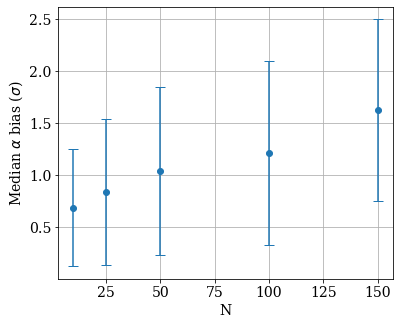

In [ ]:
fig, axes = plt.subplots(figsize=(6, 5))
plt.errorbar(N_samples_range, med_sigma_boot_range, yerr=std_sigma_boot_range, fmt='o', capsize=5.0)
plt.xlabel("N")
plt.ylabel("Median $\\alpha$ bias ($\sigma$)")
plt.grid()
# plt.semilogy()
# plt.savefig(plotdir+'alpha_3.5_lam_1_n_vs_bias.pdf')
plt.show()

# 3D Inference, MCMC test

https://github.com/kazewong/TutorialsAndExplains/blob/main/HBA_explain/Session_version.ipynb

In [14]:
import emcee
import corner

In [55]:
# Calculate the requisite mu_m1, sigma_m1 for the Event Likelihoods
m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc[:500], df_eta[:500], biased=False)
Ns = len(m1_mu_sampled)
Nt = Ns

In [238]:
m1_min_int = 2.
m1_max_int= 200.
n_m1_int= 10000

m1_mu_sampled, m1_sigma_events = sample_m1_events(df_mc[:200], df_eta[:200], biased=False)
Ns = len(m1_mu_sampled)
Nt = Ns



m1_int_range = np.geomspace(m1_min_int, m1_max_int, n_m1_int)
posteriors = np.zeros((Nt, n_m1_int))

for i in range(Nt):
    posteriors[i] = normal_dist(m1_int_range, m1_mu_sampled[i], m1_sigma_events[i])

def lnprob(hyper):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]

    prior = p_m1(m1_int_range, alpha, m1_min_pow, m1_max_pow)
    # make sure the prior is normalized 
    # (becomes a problem with geomspaced bins where the first few numbers are 0s)
    prior = prior / integrate.trapezoid(prior, m1_int_range)
    
    integrands = prior*posteriors
    integrals = integrate.trapezoid(integrands, m1_int_range, axis=1)
    
    integrals = integrals[integrals!=0]
    
    return np.sum(np.log(integrals))

In [239]:
hyper_test = [-3.2, 5.3, 110.4]

start = time.time()
print(lnprob(hyper_test))
end = time.time()

print(f"Time: {end-start:.5f} s")

-501.3459580348156
Time: 0.02693 s


In [240]:
def population_posterior(hyper):
    alpha = hyper[0]
    m1_min_pow = hyper[1]
    m1_max_pow = hyper[2]

    if (alpha>-1.0) or (alpha<-5.0):
        return -np.inf
    if (m1_min_pow>40.0) or (m1_min_pow<0.1):
        return -np.inf
    if (m1_max_pow>1000.0) or (m1_max_pow<20.0):
        return -np.inf

    else:
        return lnprob(hyper)

In [241]:
# hyperparams_fiducial=[alpha_inj, mmin_inj, mmax_inj]
# N_MCMC=4000

# # number of hyperparameters:
# ndim = len(hyperparams_fiducial)
#     # total number of walkers:
# multiplicity = 10
# nwalkers = 2 * ndim * multiplicity
#     # initialize sampler:
# sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, args=[m1_mu_sampled, m1_sigma_events]) 
# # initial condition:
# hyperparams_0 = np.zeros(shape=(nwalkers, ndim))
# for i in range(0, ndim):
#     hyperparams_0[:, i] = hyperparams_fiducial[i] + (np.random.rand(nwalkers)-0.5)
#     # burn-in sampler:
# state = sampler.run_mcmc(hyperparams_0, 100)
# sampler.reset()
#     # explore parameter space:
# sampler.run_mcmc(state, N_MCMC, progress=True)
# # get flat results:
# flat_samples = sampler.get_chain(discard=0, flat=True)

In [250]:
ndim, nwalkers = 3, 10

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior)

p0 = np.random.uniform([-3.4, 4.96, 95], [-3.6, 5.04, 105], size=(nwalkers,ndim))

# burn-in sampler:
state = sampler.run_mcmc(p0, 50, progress=True)
sampler.reset()


100%|██████████| 50/50 [00:02<00:00, 22.67it/s]


In [251]:
N_MCMC = 1000

# explore parameter space:
sampler.run_mcmc(state, N_MCMC, progress=True)

100%|██████████| 1000/1000 [01:02<00:00, 16.03it/s]


State([[ -3.4584444    4.99289457 321.29905616]
 [ -3.597159     4.99081615 986.25122727]
 [ -3.94546506   4.99412539 422.36864177]
 [ -3.58153764   5.0615033   52.94737599]
 [ -3.75942991   4.99046611 206.80329942]
 [ -3.54752395   4.98886189 830.41598895]
 [ -3.53467788   4.97149768 563.43763933]
 [ -3.3248206    5.02504592 987.58501979]
 [ -3.54609508   4.9675659  289.10734179]
 [ -3.59452671   4.97076131 194.57166078]], log_prob=[-461.24652696 -461.14390391 -463.17255595 -461.83486767 -461.72444989
 -461.11220142 -461.17290761 -462.43704686 -461.21393128 -461.25535636], blobs=None, random_state=('MT19937', array([2743929899, 1323855979, 3130744601, 4149663703, 3745879529,
       2605610516, 3501400264, 3397619752, 1564313261, 3170409698,
       4144898729, 2780084481,  485534267, 1872287744,  822743464,
       1929466724,  673375377, 3374185491, 1849488542, 2116062197,
        425778322,  801212531, 2675672632, 1368751060, 2508419504,
       4121750249,  199609492, 2385469818, 3835

In [248]:
# get flat results:
flat_samples = sampler.get_chain(discard=50, flat=True)

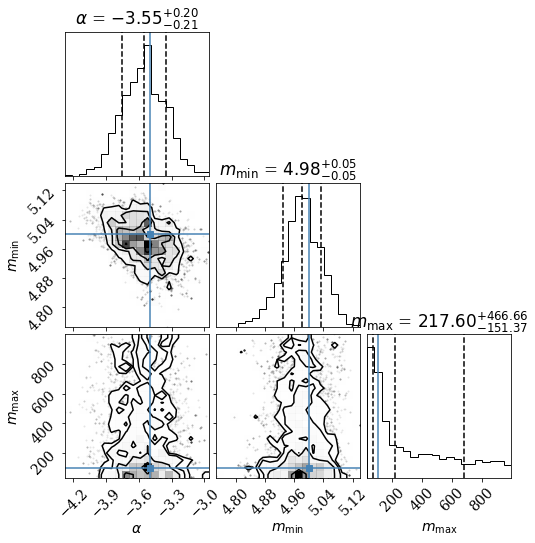

In [253]:
# samples
fig = corner.corner(flat_samples, truths=[alpha_inj, mmin_inj, mmax_inj],\
                    labels=[r"$\alpha$", r"$m_{\rm min}$", r"$m_{\rm max}$"],\
                        quantiles=[0.16, 0.5, 0.84],\
                            show_titles=True,)

In [64]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

samples[:, 2] = np.exp(samples[:, 2])
alpha_mcmc, mmin_mcmc, mmax_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(alpha_mcmc)
print(mmin_mcmc)
print(mmax_mcmc)

(-3.4966790808088533, 0.15076550736544148, 0.19201569600322177)
(5.031307064895121, 0.03908208511158051, 0.04365017382125913)
(1.9185051804374776e+59, 2.2006582984969414e+90, 1.9185051804374776e+59)


# Scipy curve_fit test

In [38]:
mask = (m1_mu_sampled<2000)

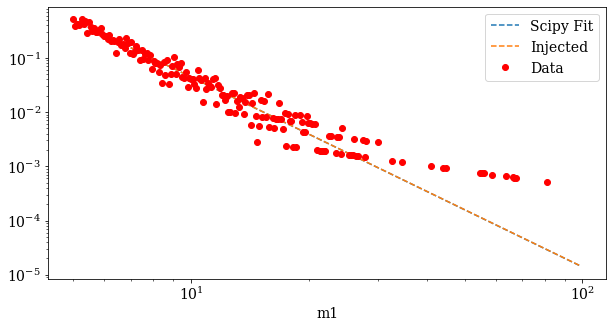

[-3.50176719e+00  4.99999999e+00  2.64760687e+04]


In [41]:
target_func = p_m1
bins = np.geomspace(5, 100, 300)

y, X = np.histogram(m1_mu_sampled[mask], bins=bins, density=True)
X = X[:-1]
# plt.plot(X, y)
# plt.loglog()


popt, pcov = optimize.curve_fit(target_func, X, y, p0=[-3.1, 5, 100])

plt.figure(figsize=(10, 5))
plt.plot(X, target_func(X, *popt), '--', label='Scipy Fit')
# plt.plot(X, p_m1(X,  mu_alpha, 5, 100), '--', label='Best-Fit')
plt.plot(X, p_m1(X,  alpha_inj, 5, 100), '--', label='Injected')

# plt.plot(X, len(df_mc)*pareto.pdf(X, b)/70.0, label='pareto')

plt.plot(X, y, 'ro', label='Data')
plt.xlabel("m1")
plt.loglog()
plt.legend()

# plt.xlim(30, 70)

plt.show()


print(popt)